# PyKEEN Tutorial

This tutorial will guide you through the process of using PyKEEN for knowledge graph embedding. We will cover the following topics:

1. Data Preparation
2. Creating SPO triples
3. Setting up Models
4. Evaluations

Before we start, make sure you have installed the PyKEEN library. If not, you can install it by running `!pip install pykeen` in a code cell.

## 1. Data Preparation

In this section, we will load and prepare our data. The data should be in a TSV (Tab-Separated Values) format. We will use pandas to load the data and prepare it for PyKEEN.

In [1]:
import pandas as pd

# Define the subjects, predicates, and objects
subjects =   ['Alice', 'Bob', 'Charlie', 'David', 'Eve', 'Alice', 'Bob', 'David', 'Eve', 'Frank', 'David']
predicates = ['like', 'like', 'like', 'like', 'like', 'has', 'has', 'has' , 'has','has', 'has']
objects =    ['movie', 'movie', 'movie', 'music', 'music', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat']

# Create a dataframe
df = pd.DataFrame({'subject': subjects, 'predicate': predicates, 'object': objects})

# Save the dataframe to a TSV file
df.to_csv('dataset10.csv', sep=',', index=False, header=False)
df.to_csv('dataset10.tsv', sep='\t', index=False, header=False)

df

,subject,predicate,object
0,Alice,like,movie
1,Bob,like,movie
2,Charlie,like,movie
3,David,like,music
4,Eve,like,music
5,Alice,has,cat
6,Bob,has,cat
7,David,has,dog
8,Eve,has,dog
9,Frank,has,dog


## 2. Creating SPO triples

Once we have our data loaded, we need to create SPO (Subject-Predicate-Object) triples. These triples represent the relationships between entities in our knowledge graph. In PyKEEN, we can use the `TriplesFactory` class to create these triples.

In [2]:
import pykeen
pykeen.env()

Key,Value
OS,posix
Platform,Linux
Release,5.15.0-73-generic
Time,Sat Jun 10 21:49:43 2023
Python,3.8.16
PyKEEN,1.10.2-dev
PyKEEN Hash,UNHASHED
PyKEEN Branch,
PyTorch,2.0.1+cu117
CUDA Available?,false


In [3]:
from pykeen.triples import TriplesFactory

# Assuming your dataframe has columns 'subject', 'predicate', 'object'
triples_factory = TriplesFactory.from_labeled_triples(
    triples=df[['subject', 'predicate', 'object']].values,
)

# Display the first few triples
triples_factory.triples

/home/wasit/miniconda3/envs/demokg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Reconstructing all label-based triples. This is expensive and rarely needed.


array([['Alice', 'has', 'cat'],
       ['Alice', 'like', 'movie'],
       ['Bob', 'has', 'cat'],
       ['Bob', 'like', 'movie'],
       ['Charlie', 'like', 'movie'],
       ['David', 'has', 'cat'],
       ['David', 'has', 'dog'],
       ['David', 'like', 'music'],
       ['Eve', 'has', 'dog'],
       ['Eve', 'like', 'music'],
       ['Frank', 'has', 'dog']], dtype='<U7')

In [4]:
# training, validation, testing = triples_factory.split(ratios=(.6, .2, .2))
training = triples_factory
validation = triples_factory
testing = triples_factory

# d=training
# id_to_entity={v: k for k, v in d.entity_to_id.items()}
# id_to_relation={v: k for k, v in d.relation_to_id.items()}

# for i in d.map_triples(d.triples):
#     s,p,o =int(i[0]), int(i[1]), int(i[2])
#     h,r,t = id_to_entity[s], id_to_relation[p], id_to_entity[o]
#     print(f"{s:2d}:{h:7}{p:2d}:{r:7} {o:2d}:{t:7}")

## 3. Setting up Models

Now that we have our triples, we can set up our knowledge graph embedding model. PyKEEN provides several models for this purpose. In this tutorial, we will use the TransE model as an example. We will also split our data into training and testing sets.

No random seed is specified. Setting to 3065222434.
No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|██████████████████████████████| 30/30 [00:02<00:00, 12.57epoch/s, loss=0.0602, prev_loss=0.238]
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|██████████████████████████████████████████████████████████████| 11.0/11.0 [00:00<00:00, 323triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

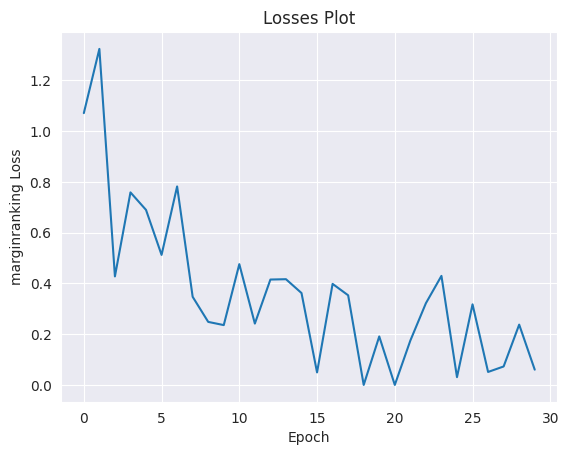

In [5]:
from pykeen.pipeline import pipeline

num_epochs=30
embedding_dim=10

result = pipeline(
    model='TransE',
#     loss="softplus",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=embedding_dim, random_seed=42),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=num_epochs, use_tqdm_batch=False),  # Increase the number of epochs
    negative_sampler='bernoulli',
    training_loop='sLCWA',
#     negative_sampler='basic',
)

# The trained model is stored in the pipeline result
model = result.model

#plot loss
result.plot_losses()

## 4. Evaluations

After training our model, we can evaluate its performance. PyKEEN provides several evaluation metrics, such as Hits@10, Mean Rank, and Mean Reciprocal Rank. These metrics can be calculated using the `Evaluator` class.

In [6]:
from pykeen.evaluation import RankBasedEvaluator
# The result object also contains the evaluation metrics result.metric_results.to_df()

# Create an evaluator
evaluator = RankBasedEvaluator()

# Evaluate the model
metrics = evaluator.evaluate(result.model, testing.mapped_triples, additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

# Print the metrics
#Mean Reciprocal Rank
print(f"MRR: {metrics.get_metric('mean_reciprocal_rank'):0.2f}")
print(f"Hits@1: {metrics.get_metric('hits@1'):0.2f}")
print(f"Hits@3: {metrics.get_metric('hits@3'):0.2f}")
print(f"Hits@5: {metrics.get_metric('hits@5'):0.2f}")
print(f"Hits@10: {metrics.get_metric('hits@10'):0.2f}")


INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|██████████████████████████████████████████████████████████████| 11.0/11.0 [00:00<00:00, 189triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


MRR: 0.81
Hits@1: 0.64
Hits@3: 0.95
Hits@5: 1.00
Hits@10: 1.00


In [7]:
import numpy as np
from pykeen.predict import predict_all
pack = predict_all(model=result.model, k=20)
from pykeen.predict import predict_triples

X_unseen = np.array([
        ['Alice', 'has', 'cat'],
        ['Bob', 'has', 'cat'],
        ['Alice', 'has', 'dog'],
        ['Bob', 'has', 'dog'],
        ['Charlie', 'has', 'cat'],
        ['Frank', 'like', 'music'],
    ])

X_unseen_factory = TriplesFactory.from_labeled_triples(
    triples=X_unseen,
)

pack = predict_triples(model=result.model, triples=X_unseen_factory)
df = pack.process(factory=X_unseen_factory).df

df.nlargest(n=10, columns="score")
# pred = pack.process(factory=result.training)
# pred_annotated = pred.add_membership_columns(training=result.training)
# pred_annotated.df

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
1,0,Alice,0,has,5,dog,-6.274148
0,0,Alice,0,has,4,cat,-6.670362
5,3,Frank,1,like,6,music,-7.391073
3,1,Bob,0,has,5,dog,-7.529594
2,1,Bob,0,has,4,cat,-7.894056
4,2,Charlie,0,has,4,cat,-8.398788


## 5. Embedding Visualization

Visualizing the embeddings can provide some insights into the relationships between entities in our knowledge graph. We can use Principal Component Analysis (PCA) to reduce the dimensionality of our embeddings and then plot them.

(-2.0, 2.0)

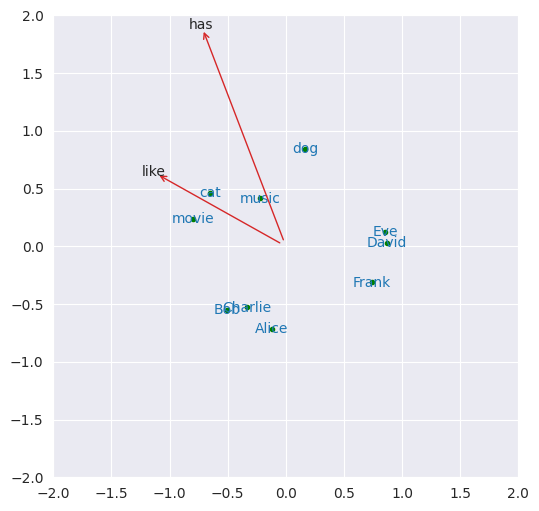

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

entitie_list=list(triples_factory.entity_to_id.keys())
relation_list =list(triples_factory.relation_to_id.keys())

entity_embeddings = model.entity_representations[0](indices=None).detach().numpy()
relation_embeddings = model.relation_representations[0](indices=None).detach().numpy()


pca = PCA(n_components=2)
m = pca.fit(entity_embeddings)


plt.figure(figsize=(6, 6))
eu = m.transform(entity_embeddings)
plt.plot(eu[:, 0], eu[:, 1],'.g')
for i, entity in enumerate(entitie_list):
    plt.annotate(
        text=entity,
        xy=(eu[i, 0], eu[i, 1]),
        color="tab:blue",
        ha="center", va="center"
    )

    
ru = pca.transform(relation_embeddings)
for i, relation in enumerate(relation_list):
    plt.annotate(
        text=relation,
        xy=(0,0), xytext=(ru[i, 0], ru[i, 1]),
        arrowprops=dict(
            arrowstyle="<-",
            color="tab:red",
            shrinkA=5,
            shrinkB=5,
            patchA=None,
            patchB=None,
            connectionstyle="arc3,rad=0."
        )
    )

plt.xlim([-2, 2])
plt.ylim([-2, 2])


In [9]:
result.training

TriplesFactory(num_entities=10, num_relations=2, create_inverse_triples=False, num_triples=11)